In [1]:
#  import des biblio

import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import os
from os import listdir
from sklearn import cluster, metrics
import time
import cv2
from keras.preprocessing import image
from sklearn.manifold import TSNE
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [2]:
# chargement du dataset
df=pd.read_csv('./exemple_essai/Flipkart/flipkart_com-ecommerce_sample_1050.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

# la  variable categorie 

In [4]:

# Fonction pour extraire la catégorie
def extract_category(row):
    pos = str(row['product_category_tree']).find(">>")
    return str(row['product_category_tree'])[:pos]

# Appliquer la fonction à chaque ligne du DataFrame
df['category'] = df.apply(extract_category, axis=1)
df['category'] = df['category'].str[2:]

In [5]:
df=df[['product_name', 'image', 'category']]

In [6]:
df

,product_name,image,category
0,Elegance Polyester Multicolor Abstract Eyelet ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing
1,Sathiyas Cotton Bath Towel,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care
2,Eurospa Cotton Terry Face Towel Set,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care
3,SANTOSH ROYAL FASHION Cotton Printed King size...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing
4,Jaipur Print Cotton Floral King sized Double B...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing
...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,958f54f4c46b53c8a0a9b8167d9140bc.jpg,Baby Care
1046,Wallmantra Large Vinyl Sticker Sticker,fd6cbcc22efb6b761bd564c28928483c.jpg,Baby Care
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,5912e037d12774bb73a2048f35a00009.jpg,Baby Care
1048,Wallmantra Medium Vinyl Sticker Sticker,c3edc504d1b4f0ba6224fa53a43a7ad6.jpg,Baby Care


# Affichage des images

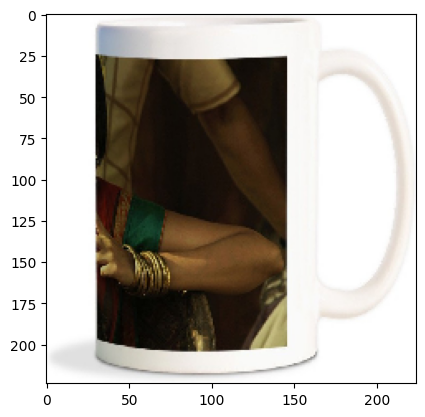

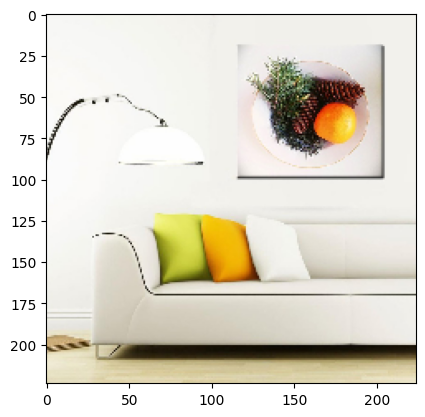

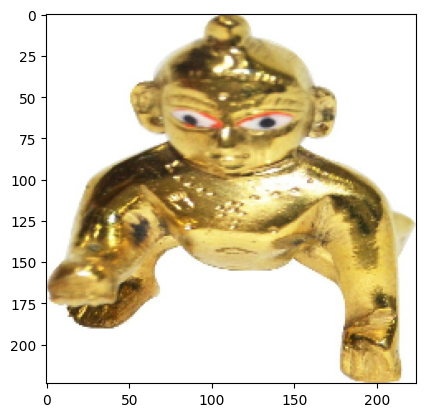

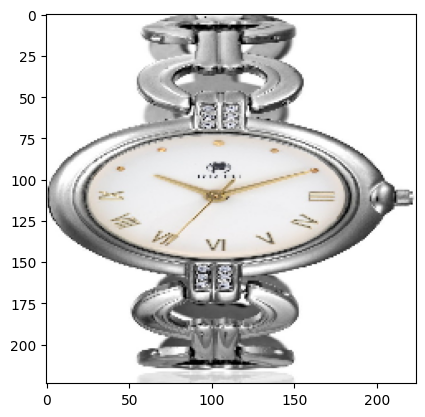

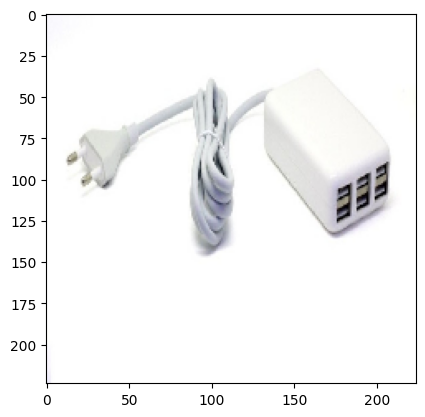

In [9]:

img_folder='./exemple_essai/Flipkart/images/'
for index, row in df.sample(5).iterrows():
    img_path = img_folder + row['image']
    # Afficher l'image
    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.show()

# Application d'egalisation de l'histogramme

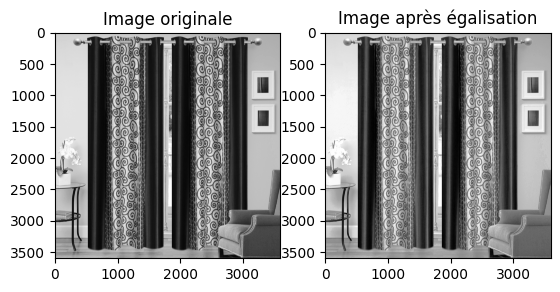

In [161]:
# Chargement d'une image en niveaux de gris
img = cv2.imread('./exemple_essai/Flipkart/images/55b85ea15a1536d46b7190ad6fff8ce7.jpg', cv2.IMREAD_GRAYSCALE)

# égalisation de l'histogramme
img_equalized = cv2.equalizeHist(img)

# image originale et image après égalisation
plt.subplot(121), plt.imshow(img, cmap='gray'), plt.title('Image originale')
plt.subplot(122), plt.imshow(img_equalized, cmap='gray'), plt.title('Image après égalisation')
plt.show()

# exemple d'extraction des keypoints et des descripteurs

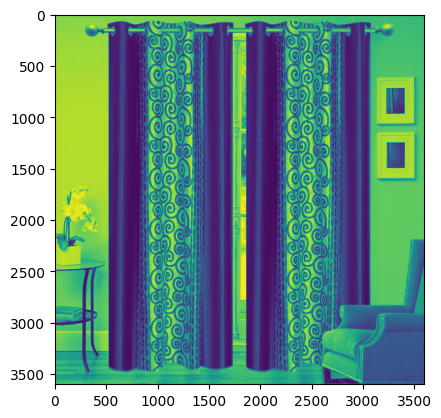

Descripteurs :  (500, 32)

[[190 236 102 ...  55  46 222]
 [ 40 189 122 ... 128 198 171]
 [ 34 239 115 ... 146 166 172]
 ...
 [130  67   6 ...  21 161 208]
 [ 34 189  32 ...  12 187 222]
 [ 93 187  88 ... 132 236 125]]


In [162]:

# Chargement de l'image
img = cv2.imread('./exemple_essai/Flipkart/images/55b85ea15a1536d46b7190ad6fff8ce7.jpg', cv2.IMREAD_GRAYSCALE)

# creation objet ORB
orb = cv2.ORB_create()

# Détection des keypoints et calcul des descripteurs
keypoints, descriptors = orb.detectAndCompute(img, None)

# Affichage des keypoints sur l'image
img_with_keypoints = cv2.drawKeypoints(img, keypoints, None)
plt.imshow(img)
plt.show()
# Afficher l'image avec les keypoints
#cv2.imshow('Image avec keypoints', img_with_keypoints)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

print("Descripteurs : ", descriptors.shape)
print()
print(descriptors)


# ORB

In [166]:
# Extraction des Features pour toutes les images avec ORB
orb_keypoints = []
temps1 = time.time()
orb = cv2.ORB_create()
img_folder = './exemple_essai/Flipkart/images/'
# parcours des images
for index, row in df.iterrows():
    img_path = img_folder + row['image']
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error loading image: {img_path}")
        continue  

    res = cv2.equalizeHist(image)
    kp, des = orb.detectAndCompute(res, None)
    orb_keypoints.append(des)

orb_keypoints_all = np.concatenate(orb_keypoints, axis=0)

print()
print("Nombre de descripteurs : ", orb_keypoints_all.shape)

duration1 = time.time() - temps1
print("temps de traitement ORB descriptor : ", "%15.2f" % duration1, "secondes")



Nombre de descripteurs :  (520145, 32)
temps de traitement ORB descriptor :            87.88 secondes


## Création des clusters de descripteurs

In [167]:

import time 
# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(orb_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(orb_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  721
Création de 721 clusters de descripteurs ...


C:\Users\VORPC\datascientist\projet6\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


temps de traitement kmeans :            11.16 secondes


## Création des features des images


In [168]:
# Creation des histogrammes (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation d'une matrice des histogrammes
hist_vectors=[]

for i, image_desc in enumerate(orb_keypoints) :
    if i%100 == 0 : print(i)  
    hist = build_histogram(kmeans, image_desc, i) #calculer les histogrammes
    hist_vectors.append(hist) #l'histogramme est e  vecteur des features

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")



0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             5.43 secondes


### Réduction de dimension PCA

In [169]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 721)
Dimensions dataset après réduction PCA :  (1050, 579)


### Réduction de dimension T-SNE


In [170]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["category"]
print(df_tsne.shape)

(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images

###  Création de clusters à partir du T-SNE

In [171]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)


(1050, 4)


C:\Users\VORPC\datascientist\projet6\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

C:\Users\VORPC\AppData\Local\Temp\ipykernel_13676\2962841251.py:3: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(
C:\Users\VORPC\AppData\Local\Temp\ipykernel_13676\2962841251.py:13: UserWarning: 
The palette list has fewer values (4) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


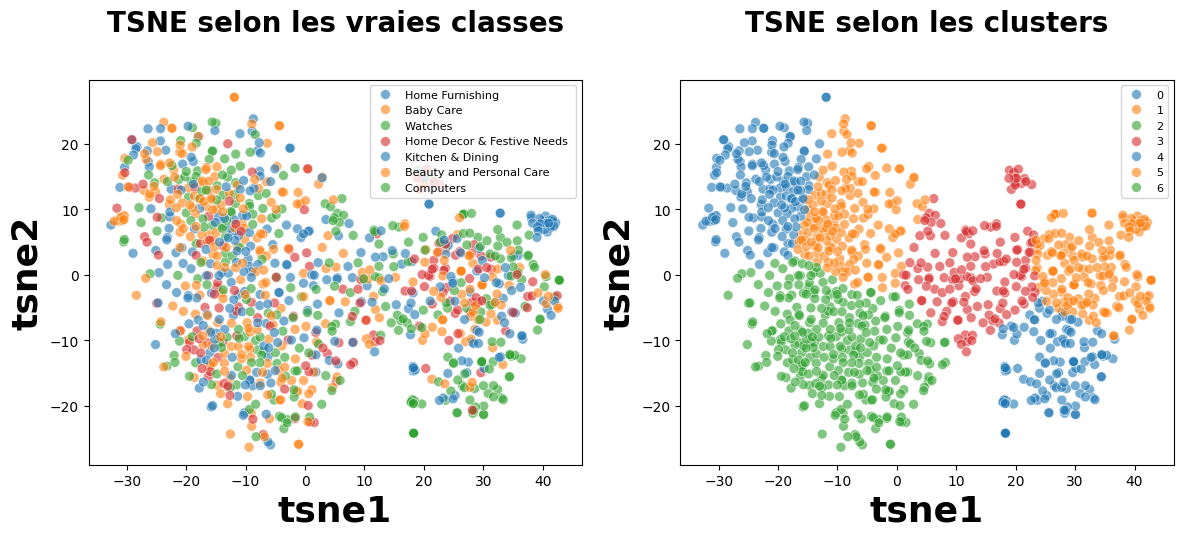

ARI :  0.03415427949379175


In [172]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 20, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 8}) 

plt.subplot(1,2,2)
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 20, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 8}) 

plt.show()

labels = df["category"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

# VGG16

In [317]:
# Chargement du modele sans classifier layers
model = VGG16(include_top=False, input_shape=(300, 300, 3))


In [318]:
# liste pour les features
features_list1=[]
# chargement du modele
model = VGG16()
# suppression des couches denses
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# extraction des features
deb_time=time.time()
for index, row in df.iterrows():
    img_path = img_folder + row['image']
    # Charger chaque image et la prétraiter 
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Extraire les caractéristiques de l'image
    features1 = model.predict(img_array)
    
    # Ajouter les caractéristiques à la liste
    features_list1.append(features1)
duree=time.time()-deb_time
print(duree)
print(features1.shape)


1/1 [==============================] - 0s 488ms/step


C:\Users\VORPC\datascientist\projet6\env\Lib\site-packages\PIL\Image.py:3182: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 [==============================] - 0s 495ms/step
702.7733340263367
(1, 4096)


In [319]:
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [320]:
features_array1 = np.vstack(features_list1)

print(features_array1.shape)
# reduction de dimensions avec pca
pca1 = decomposition.PCA()
feat_pca1= pca1.fit_transform(features_array1.reshape(1050, -1))
print(feat_pca1.shape)

# t-SNE avec les vecteurs de caractéristiques 
features_flat1 = feat_pca1.reshape(feat_pca1.shape[0], -1)
tsne1 = TSNE(n_components=2,perplexity=62, random_state=42)
features_tsne1 = tsne1.fit_transform(features_flat1)

# df_tsne pour la visulaisation 
df_tsne1 = pd.DataFrame(data=features_tsne1, columns=['tsne1', 'tsne2'])

# category 
df_tsne1['category'] = df['category']


(1050, 4096)
(1050, 1050)


In [321]:
# clustering avec Kmeans
from sklearn.cluster import KMeans
kmeans1 = KMeans(n_clusters=7, random_state=42)
df_tsne1['cluster'] = kmeans1.fit_predict(features_tsne1)
df_tsne1["class"] = df["category"]

C:\Users\VORPC\datascientist\projet6\env\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## Analyse visuelle : affichage T-SNE selon catégories d'images/Clusters Kmeans

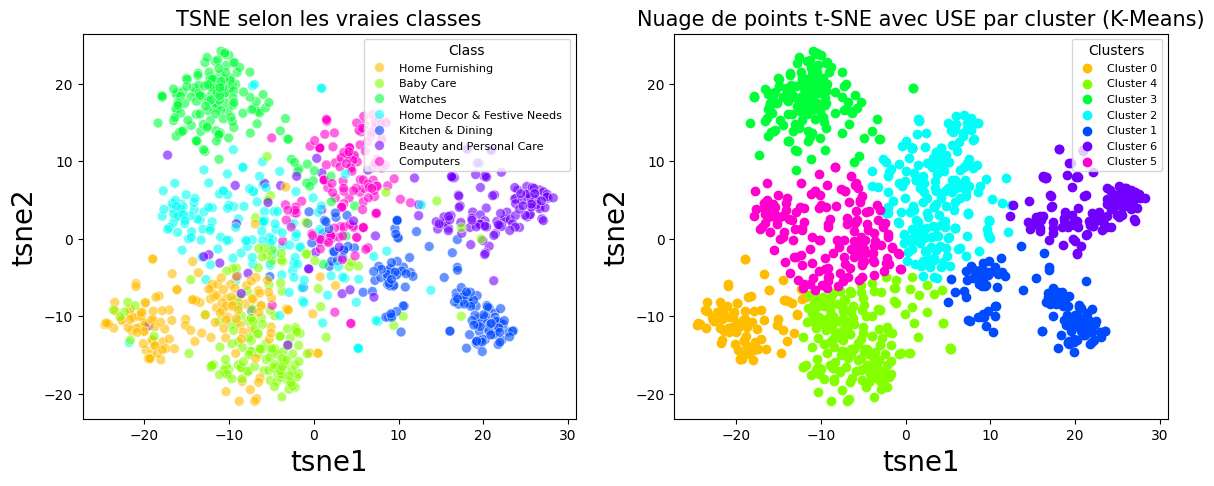

In [322]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
class_palette=sns.color_palette('hsv', n_colors=7)
sns.scatterplot(x="tsne1", y="tsne2", hue="class",palette=class_palette, s=50, alpha=0.6,
    data=df_tsne1)
plt.legend(title='Class',prop={'size': 8})   
plt.title('TSNE selon les vraies classes', fontsize = 15)
plt.xlabel('tsne1', fontsize = 20)
plt.ylabel('tsne2', fontsize = 20)

plt.subplot(1,2,2)
# palette des couleurs
cluster_palette = sns.color_palette("hsv", len(df_tsne1['cluster'].unique()))

# nuage de points avec coloration par cluster
for i, cluster in enumerate(df_tsne1['cluster'].unique()):
    subset = df_tsne1[df_tsne1['cluster'] == cluster]
    plt.scatter(subset['tsne1'], subset['tsne2'], label=f'Cluster {cluster}', color=cluster_palette[i])

plt.legend(title='Clusters',prop={'size': 8})

plt.title('Nuage de points t-SNE avec USE par cluster (K-Means)',fontsize = 15)
plt.xlabel('tsne1',fontsize = 20)
plt.ylabel('tsne2',fontsize = 20)
plt.show()

## Calcul ARI

In [323]:
labels = df_tsne1["class"]
print("ARI : ", metrics.adjusted_rand_score(labels, df_tsne1['cluster']))

ARI :  0.553850091874624
